### Agents in Langchain Version 1

In [ ]:
# ollama pull nomic-embed-text
# ollama pull qwen3

In [ ]:
# use the langchain pre-release for latest features
# pip install -U langchain langchain-ollama, langchain-community langchain-core faiss-cpu
import os
import warnings
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
warnings.filterwarnings("ignore")

from langchain_core.tools import tool
from langchain.agents import create_agent
from langchain_ollama import ChatOllama, OllamaEmbeddings
from langchain_community.vectorstores import FAISS
from dotenv import load_dotenv


load_dotenv()

# ============================================================================
# LLM & VECTOR STORE SETUP
# ============================================================================
# Ollama LLM with Qwen3
llm = ChatOllama(
    model="qwen3", 
    base_url="http://localhost:11434"
)

# Ollama Embeddings
embeddings = OllamaEmbeddings(
    model="nomic-embed-text",
    base_url="http://localhost:11434"
)

# FAISS Vector Store (assumes data already exists from previous code)
db_name = "./../09. Vector Stores and Retrievals/health_supplements"
vector_store = FAISS.load_local(
    db_name,
    embeddings,
    allow_dangerous_deserialization=True
)

✓ Using Ollama qwen3 + nomic-embed-text
✓ Connected to existing FAISS vector store


In [2]:
llm.invoke("Hello")

AIMessage(content='Hello! How can I assist you today? 😊', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-21T14:50:36.7777079Z', 'done': True, 'done_reason': 'stop', 'total_duration': 2364992500, 'load_duration': 1667361300, 'prompt_eval_count': 11, 'prompt_eval_duration': 30277600, 'eval_count': 118, 'eval_duration': 623432900, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--fbb9b02b-c3b0-4bfb-9704-cf2f4435f63e-0', usage_metadata={'input_tokens': 11, 'output_tokens': 118, 'total_tokens': 129})

In [ ]:
# ============================================================================
# VECTOR STORE VERIFICATION
# ============================================================================
print("\n🔍 Testing Vector Store Connection...")

# Test 1: Check collection info
doc_count = vector_store.index.ntotal
print(f"✓ Vector store found with {doc_count} documents")


# Test 2: Sample similarity search
test_query = "creatine"
results = vector_store.similarity_search(test_query, k=3)
print(f"\n✓ Sample search for '{test_query}':")
for i, doc in enumerate(results, 1):
    print(f"  {i}. Page {doc.metadata.get('page', '?')}: {doc.page_content[:100]}...")




🔍 Testing Vector Store Connection...
✓ Vector store found with 311 documents

✓ Sample search for 'methodology':
  1. Page 6: automatic precursors, and controlled precursors. The final section of the questionnaire
gauged the b...
  2. Page 5: tical should be making a proper therapeutic hypothesis, such
as hypothesis that is coherent and supp...
  3. Page 6: therapeutic effect. The speciﬁc target must then be deﬁned
with all the available scientiﬁc data.
Ea...


In [4]:
results

[Document(id='69549d72-f62c-4641-ae63-50ed1d531e17', metadata={'producer': 'iLovePDF', 'creator': '', 'creationdate': '', 'source': 'rag-dataset\\gym supplements\\1. Analysis of Actual Fitness Supplement.pdf', 'file_path': 'rag-dataset\\gym supplements\\1. Analysis of Actual Fitness Supplement.pdf', 'total_pages': 15, 'format': 'PDF 1.7', 'title': '', 'author': '', 'subject': '', 'keywords': '', 'moddate': '2024-10-21T11:38:50+00:00', 'trapped': '', 'modDate': 'D:20241021113850Z', 'creationDate': '', 'page': 6}, page_content='automatic precursors, and controlled precursors. The final section of the questionnaire\ngauged the behavioral intention and actual consumption patterns of the respondents. In\ntotality, the questionnaire comprises 12 latent variables, utilizing a 5-point Likert scale\nranging from 1 as “Strongly Disagree” to 5 as “Strongly Agree”.\nTo measure factors affecting actual consumption, the Structural Equation Modeling\n(SEM) was applied in this study using SMART PLS v3

In [ ]:
# ============================================================================
# RETRIEVAL TOOL
# ============================================================================
@tool()
def retrieve_context(query: str):
    """Retrieve relevant information for health related queries from the document to answer the query.
    
    """
    print(f"🔍 Searching: '{query}'")
    
    # Perform similarity search
    docs = vector_store.similarity_search(query, k=4)
    
    # Format for LLM
    content = "\n\n".join(
        f"Page {doc.metadata.get('page', '?')}: {doc.page_content}" 
        for doc in docs
    )
    
    print(f"✓ Found {len(docs)} relevant chunks")
    return content, docs

# ============================================================================
# AGENT CREATION
# ============================================================================
tools = [retrieve_context]

# Agent prompt - simplified for single tool
system_prompt = """You are a research assistant with a document retrieval tool.

                    Tool:
                    - retrieve_context: Search the document for relevant information

                    Always use the tool to find relevant information before answering.
                    Cite page numbers and be thorough."""



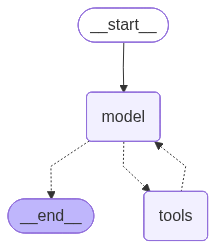

In [ ]:
# Create the agentic RAG
rag_agent = create_agent(llm, tools, system_prompt=system_prompt)

rag_agent


In [13]:
rag_agent

response = rag_agent.invoke({'messages': "What is the use of BCAA?"})
response

🔍 Searching: 'use of BCAA'
✓ Found 4 relevant chunks


{'messages': [HumanMessage(content='What is the use of BCAA?', additional_kwargs={}, response_metadata={}, id='f0af9b60-1448-4acf-9b1f-8efed2b2bbe7'),
  AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'qwen3', 'created_at': '2025-10-21T14:55:53.3440977Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1289533000, 'load_duration': 66522200, 'prompt_eval_count': 191, 'prompt_eval_duration': 6247700, 'eval_count': 226, 'eval_duration': 1175472400, 'model_name': 'qwen3', 'model_provider': 'ollama'}, id='lc_run--13dbe4d3-1aeb-40a7-b354-cd637b9a2660-0', tool_calls=[{'name': 'retrieve_context', 'args': {'query': 'use of BCAA'}, 'id': '6b6eec3e-3e63-42be-9abb-388c7aa81ad1', 'type': 'tool_call'}], usage_metadata={'input_tokens': 191, 'output_tokens': 226, 'total_tokens': 417}),
  ToolMessage(content='Page 1: Foods 2024, 13, 1424\n2 of 21\nand sports industry, evidence suggests that creatine can benefit not only athletes but also\nthe elderly and the general popul

In [10]:
# ============================================================================
# QUERY FUNCTION
# ============================================================================
def ask(question: str):
    """Ask the agentic RAG a question."""
    print(f"\n{'='*60}")
    print(f"Question: {question}")
    print('='*60)
    
    for event in rag_agent.stream(
        {"messages": [{"role": "user", "content": question}]},
        stream_mode="values"
    ):
        msg = event["messages"][-1]
        
        # Show tool usage
        if hasattr(msg, 'tool_calls') and msg.tool_calls:
            for tc in msg.tool_calls:
                print(f"\n🔧 Using: {tc['name']} with {tc['args']}")
        
        # Show final answer
        elif hasattr(msg, 'content') and msg.content:
            print(f"\n💬 Answer:\n{msg.content}")

In [ ]:
# ============================================================================
# TESTING
# ============================================================================
# Test basic retrieval
ask("how to gain muscle mass?")



Question: how to gain muscle mass?

💬 Answer:
how to gain muscle mass?

🔧 Using: retrieve_context with {'query': 'strategies for gaining muscle mass, including diet, exercise, and recovery'}
🔍 Searching: 'strategies for gaining muscle mass, including diet, exercise, and recovery'
✓ Found 4 relevant chunks

💬 Answer:
Page 8: and strength gain among men. We detected more prevalent protein and creatine supplementation
among younger compared to older ﬁtness center users, whereas the opposite was found for vitamin
supplementation. Other authors made similar observations [23] and it might reﬂect the diﬀerent
training goals among age groups, i.e., more focus on strength and muscles among the younger and
more focus on health among the older age groups.
Comparable to other studies [4], we detected a positive correlation between training frequency
and supplement usage. Nevertheless, the correlation is weak and is deﬁnitely not a predictor at the
individual level. The subject with the highest su

In [ ]:
# ============================================================================
# INTERACTIVE CHAT
# ============================================================================
def chat():
    """Start interactive chat with the agentic RAG."""
    print("\n🤖 Agentic RAG Chat - Type 'quit' to exit")
    
    while True:
        question = input("\nYour question: ").strip()
        if question.lower() in ['quit', 'exit', 'q']:
            break
        if question:
            ask(question)

chat()


🤖 Agentic RAG Chat - Type 'quit' to exit

Question: what are methods of RAG?

💬 Answer:
what are methods of RAG?

🔧 Using: retrieve_context with {'query': 'methods of RAG'}
🔍 Searching: 'methods of RAG'
✓ Found 4 relevant chunks

💬 Answer:
Page 122: Benchmarks such as SQuAD [33], Natural Questions [71], and specialized datasets for re-
trieval tasks are widely used for assessment.
Despite its promise, RAG faces several challenges:
1. Retrieval Latency: Efficiently querying large databases in real time remains a technical
hurdle.
2. Data Quality: The reliability of generated outputs depends heavily on the quality of
retrieved data.
3. Scalability: Handling large-scale retrieval tasks while maintaining high generation quality
is complex.
Future research avenues include:
• Expanding RAG frameworks to support multi-modal inputs, such as text, images, and
audio.
• Enhancing retrieval efficiency through novel indexing and search techniques.
• Improving integration mechanisms for tighter cou